# Document Classification with H2O VL Mississippi: A Practical Guide

In this tutorial, we'll explore how to use H2O.ai's Vision-Language model (H2OVL-Mississippi-800M) for document classification. Despite its relatively compact size of 0.8 billion parameters, this model demonstrates impressive capabilities in text recognition and document understanding tasks. 

## Background

In today's business environment, organizations deal with an overwhelming volume of documents in various formats - from invoices and contracts to resumes and technical documentation. Processing these documents efficiently requires sophisticated AI solutions that can understand both textual and visual elements. Enter H2O.ai's Vision-Language model (H2OVL-Mississippi-800M), a compact yet powerful solution that opens up numerous possibilities for document processing automation.

### Why Smaller Vision-Language Models Matter

Before diving into the implementation, let's understand why models like H2OVL-Mississippi-800M are particularly valuable:

### Diverse Document Processing Applications
- **Intelligent Document Routing**: Automatically sort incoming documents into appropriate workflows (invoices to accounting, resumes to HR, etc.)
- **Data Extraction**: Pull structured data from:
  - Purchase orders and invoices (vendor details, line items, totals)
  - Business cards (contact information, company details)
  - Medical records (patient information, diagnoses, prescriptions)
  - Financial statements (account numbers, transaction details)
- **Document Quality Assessment**: Identify poor scans, missing pages, or incorrectly oriented documents
- **Form Processing**: Handle various types of forms including:
  - Tax forms (W-2s, 1099s)
  - Insurance claims
  - Loan applications
  - Government documents
- **Table Understanding**: Extract and structure tabular data from:
  - Financial reports
  - Scientific papers
  - Technical specifications
  - Product catalogs

### Strategic Role in ML Pipelines

While larger language models (LLMs) offer impressive capabilities, using them for every step in a document processing pipeline can be computationally expensive and inefficient. A more strategic approach is to use smaller, specialized models like H2OVL-Mississippi-800M as efficient pre-processors:

1. **Initial Triage**: Use the smaller model to:
   - Classify documents
   - Extract key text and data
   - Identify relevant sections
   
2. **Focused Processing**: Pass only the relevant extracted information to larger models for:
   - Deep semantic analysis
   - Complex reasoning
   - Natural language generation
   - Decision making

This pipeline approach offers several advantages:
- **Cost Efficiency**: Minimize the use of expensive compute resources
- **Speed**: Process documents faster by using the right tool for each task
- **Scalability**: Handle larger document volumes without proportional cost increases
- **Reliability**: Smaller, specialized models often perform better at specific tasks


We'll walk through an example of classifying documents.

## Model Overview

The H2OVL-Mississippi-800M is a vision-language model that combines text and image understanding capabilities. Key features include:

- 0.8 billion parameters, offering a good balance between performance and efficiency
- Trained on 19 million image-text pairs
- Specialized in OCR, document comprehension, and interpretation of charts, figures, and tables
- Built on H2O's Danube language model architecture
- Model Card: https://huggingface.co/h2oai/h2ovl-mississippi-800m


<div style="text-align: center;">
    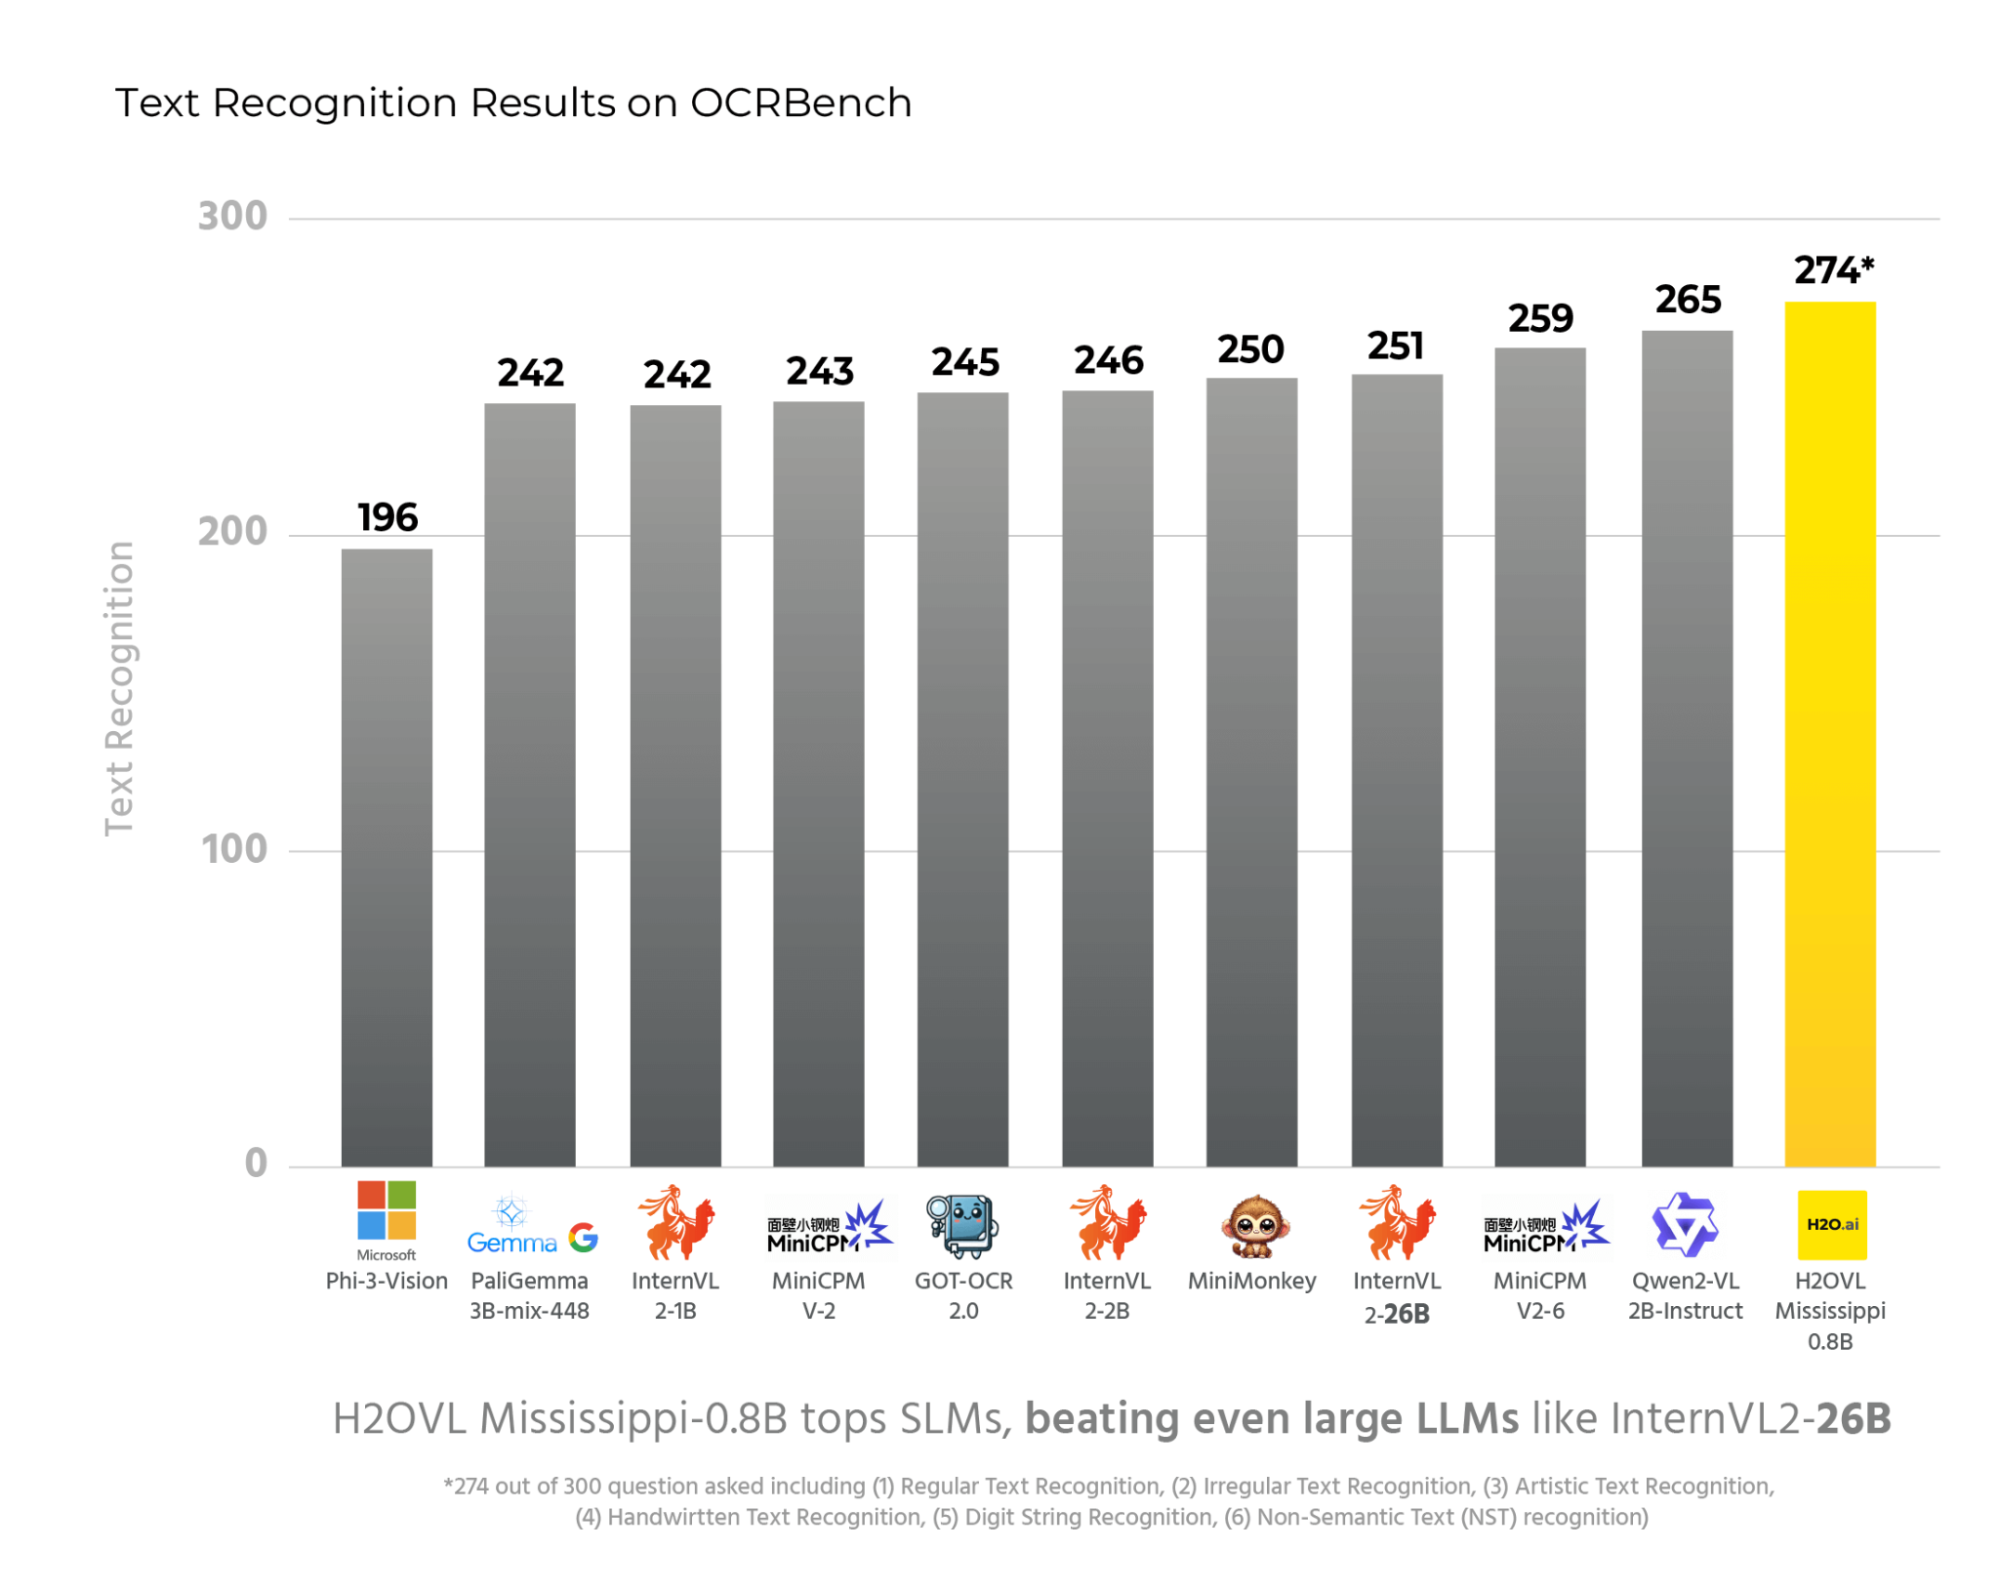
</div>


## Setup and Dependencies

First, let's install the required packages. You'll need transformers, torch, and several other dependencies:

In [8]:
#!pip install transformers torch torchvision einops timm peft sentencepiece flash_attn

Import the necessary libraries:

In [55]:
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig

## Loading the Model

The following code initializes the model and tokenizer:

In [55]:
# Load the model and tokenizer
model_path = 'h2oai/h2ovl-mississippi-800m'
# model_path = 'h2oai/h2ovl-mississippi-2b'

config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
# Disable flash attention
config.vision_config.use_flash_attn = False

model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    config=config,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)

# Generation configuration for model
generation_config = dict(max_new_tokens=500, do_sample=False)

In [69]:
def parse_json_response(response):
    """
    Extract JSON object from a response string using regular expressions.
    Assumes the response contains a JSON object that follows the format {"type": ""}.
    If model only returns a single word, then it will be converted to {"type": response}
    """
    try:
        # Use regular expression to find the JSON object in the string
        json_match = re.search(r'\{.*?\}', response)
        if json_match:
            json_str = json_match.group(0)
            return json.loads(json_str)
        elif len(response.strip().split(" ")) == 1:
            return {"type": response.strip()}
        else:
            print(f"Could not find valid JSON in response: {response}")
            return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from response: {response}")
        return None

def evaluate_model(model, tokenizer, generation_config, files, prompt):
    actual_labels = []
    predicted_labels = []
    
    for image_file, true_label in files:
        response, history = model.chat(tokenizer, image_file, prompt, generation_config, history=None, return_history=True)
        
        parsed_response = parse_json_response(response)
        #print("parsed_response: ", parsed_response)
        if parsed_response and "type" in parsed_response:
            predicted_type = parsed_response["type"]
        else:
            predicted_type = ""  # Handle cases where parsing fails or JSON is incomplete
        
        actual_labels.append(true_label)
        predicted_labels.append(predicted_type)
    
    accuracy = accuracy_score(actual_labels, predicted_labels)
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=["invoice", "news-article", "resume"])
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    
    conf_df = pd.DataFrame(conf_matrix, index=["invoice", "news-article", "resume"], columns=["invoice", "news-article", "resume"])
    
    return accuracy, conf_df

def load_image_from_file(image_file):
    return Image.open(image_file).convert("RGB")

def plot_images_with_labels(files, images_per_row=5):
    """
    Plots the given images in a grid, with their categories labeled on top.
    
    Parameters:
    - files: A list of tuples where each tuple contains (file_path, label)
    - images_per_row: Number of images to display per row in the grid (default is 5)
    """
    num_rows = (len(files) + images_per_row - 1) // images_per_row

    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(20, 4 * num_rows))
    axs = axs.flatten()

    for i, (image_file, label) in enumerate(files):
        image = load_image_from_file(image_file)        
        axs[i].imshow(image)        
        axs[i].axis('off')
        axs[i].text(10, 10, label, color='red', fontsize=15, weight='bold', backgroundcolor='white')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

## Preparing the Data

For this tutorial, we'll use a subset of the `RVL-CDIP` dataset, containing 15 images across three document categories. 
You can access these images in two ways:

- Through Kaggle: Add the `rvl-cdip-small` dataset to your notebook inputs
- Directly from GitHub: https://github.com/a-ghorbani/nb-mississippi/tree/main/data

Here's how we structure our data:

In [57]:
# List of files with their categories
files = [
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000036371.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000044003.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000080966.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000080967.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/invoice/0000113780.tif", "invoice"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000002844.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000011128.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000039666.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000081773.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/news article/0000087166.tif", "news-article"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000000869.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000566434.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000279204.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000157511.tif", "resume"),
    ("/kaggle/input/rvl-cdip-small/data/resume/0000279241.tif", "resume"),
]

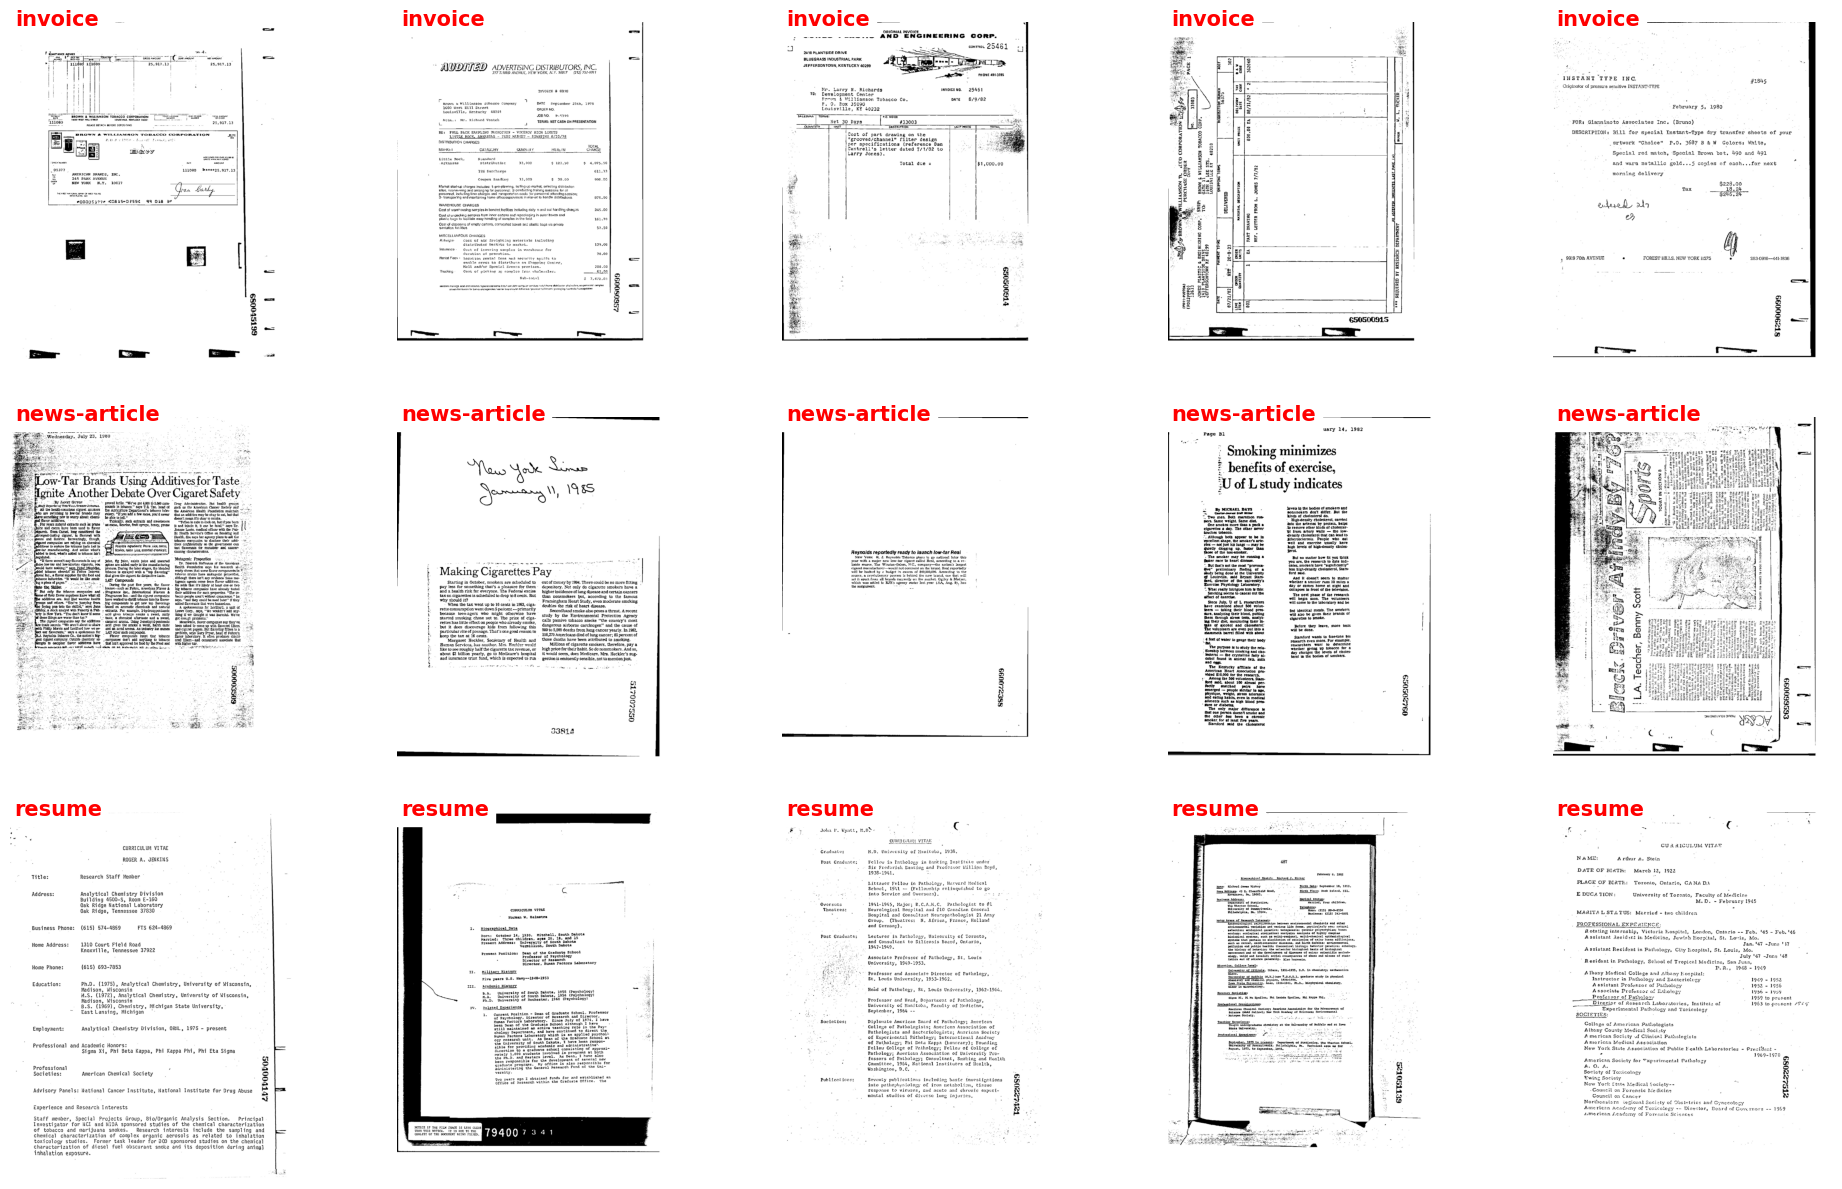

In [60]:
plot_images_with_labels(files, 5)

# Document Classification

Our classification approach is straightforward:

- Load each document image
- Send it to the model along with a prompt
- Parse the model's response to get the predicted category
- Compare predictions with actual labels

The prompt we use is quite simple:
```python
"<image>\nExtract the type of the image, categorizing it as 'invoice', 'resume', or 'news-article'. Type:"
```

In [61]:
prompt = """<image>\nExtract the type of the image, categorizing it as 'invoice', 'resume', or 'news-article'. Type: """


accuracy, confusion_df = evaluate_model(model, tokenizer, generation_config, files, prompt)
print(confusion_df)

Accuracy: 100.00%
Confusion Matrix:
              invoice  news-article  resume
invoice             5             0       0
news-article        0             5       0
resume              0             0       5


## Results

Running our evaluation on the test set yields impressive results:

**Accuracy**: 100.00%

|               | invoice | news-article | resume |
|---------------|---------|--------------|--------|
| **invoice**   |    5    |      0       |    0   |
| **news-article** |    0    |      5       |    0   |
| **resume**    |    0    |      0       |    5   |


The model achieved perfect accuracy on our test set, correctly classifying all 15 documents into their respective categories. While this is a small test set, it demonstrates the model's strong capability in distinguishing between different document types.

*Note*: It is not typically expected for a model to be 100% accurate all the time, especially since we only used 15 images. For a more comprehensive evaluation, we need to use a more diverse set of images. Nevertheless, it is still impressive to see how an 800M model can be used effectively in a broader LLM-based pipeline and for automation tasks.

## Conclusion

The H2OVL-Mississippi-800M model proves to be highly effective for document classification tasks. Its moderate size makes it practical for deployment while maintaining excellent accuracy. The simple prompt-based approach makes it easy to adapt for different document classification needs.
For the complete code and example dataset, check out the full notebook on [GitHub](https://github.com/a-ghorbani/nb-mississippi).